In [2]:
# load json file
import json
import pandas as pd
def load_json(dir_path: str):
    with open(dir_path, "r") as f:
        return json.load(f)

#llm_name = "code-llama-13b_temp_0.8"
llm_name = "deepseek-coder-7b-instruct-v1.5_temp_0.8"
eval_results = load_json(f"/mnt/scratch-artemis/haausing/code_reranking/evalplus_outputs/mbpp/{llm_name}/eval_results.json")
for task_id in eval_results["eval"]:
    eval_results["eval"][task_id] = sorted(eval_results["eval"][task_id], key=lambda x: int(x["solution_id"]))
log_probs = pd.read_pickle(f"/mnt/scratch-artemis/haausing/code_reranking/evalplus_outputs/mbpp/{llm_name}/logprobs.pkl")

In [3]:
plus_pass_list = []
base_pass_list = []
for task_id in eval_results["eval"]:
    plus_pass_list.append(sum([elem["base_status"]==elem["plus_status"]=="pass" for elem in eval_results["eval"][task_id]]))
    base_pass_list.append(sum([elem["base_status"]=="pass" for elem in eval_results["eval"][task_id]]))



In [4]:
# count the number of passes >=100
plus_passes = sum([elem >= 100 for elem in plus_pass_list])
base_passes = sum([elem >= 100 for elem in base_pass_list])
plus_pass_rate = plus_passes/len(plus_pass_list)
base_pass_rate = base_passes/len(base_pass_list)
print(f"{plus_pass_rate:.2f} {base_pass_rate:.2f}")

0.62 0.72


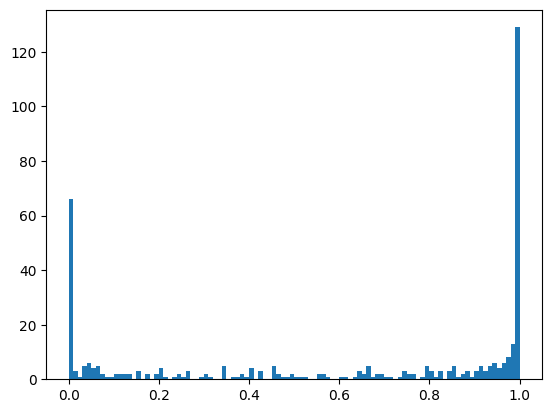

In [5]:
# plot the histogram of the number of passes
import matplotlib.pyplot as plt
plt.hist([e/200 for e in plus_pass_list], bins=100)
plt.show()



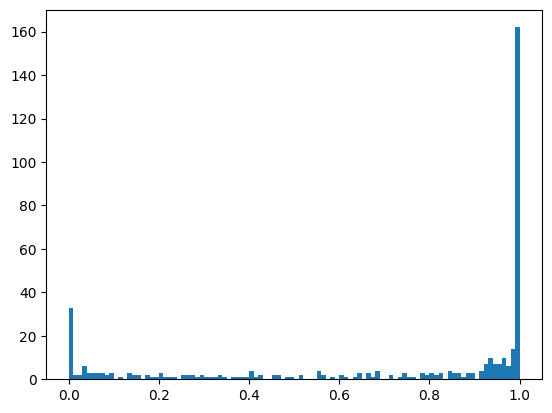

In [6]:
# do the same for base_pass_list
plt.hist([e/200 for e in base_pass_list], bins=100)
plt.show()



In [7]:
eval_results["eval"]["Mbpp/2"]

[{'task_id': 'Mbpp/2',
  'solution_id': '0',
  'solution': 'def similar_elements(list1, list2):\n    return set(list1).intersection(list2)\n\nassert set(similar_elements((3, 4, 5, 6),(5, 7, 4, 10))) == set((4, 5))',
  'base_status': 'pass',
  'plus_status': 'pass',
  'base_details': [1, 1, 1],
  'plus_details': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  'base_fail_tests': [],
  'plus_fail_te

In [8]:
from evalplus.data import get_mbpp_plus
problems = get_mbpp_plus()



In [21]:
from evalplus.data import get_human_eval_plus
humaneval_dataset = get_human_eval_plus()

In [45]:
print(humaneval_dataset["HumanEval/17"]["prompt"])



def count_distinct_characters(string: str) -> int:
    """ Given a string, find out how many distinct characters (regardless of case) does it consist of
    >>> count_distinct_characters('xyzXYZ')
    3
    >>> count_distinct_characters('Jerry')
    4
    """



In [19]:
problems["Mbpp/4"]["canonical_solution"].strip().split("\n")[0]

'import heapq as hq'

In [11]:
[e for e in problems["Mbpp/2"]]

['task_id',
 'prompt',
 'entry_point',
 'canonical_solution',
 'base_input',
 'atol',
 'plus_input',
 'contract',
 'assertion']

In [37]:
def similar_elements(list1, list2):
    return set(list1).intersection(list2)
assert set(similar_elements((3, 4, 5, 6),(5, 7, 4, 10))) == set((4, 5))

In [41]:
def similar_elements(list1, list2):
    return set(list1) & set(list2)
similar_elements((3, 4, 5, 6), (5, 7, 4, 10)) == (4, 5)

False

In [20]:
from evalplus.data import get_mbpp_plus

dataset = get_mbpp_plus()

In [21]:
def prompt_pref_sample(prompt: str, code: str,) -> str:
    sample = f"""
You are an AI programming assistant, utilizing the DeepSeek Coder model, developed by DeepSeek Company, and you only answer questions related to computer science. For politically sensitive questions, security and privacy issues, and other non-computer science questions, you will refuse to answer.
### Instruction:
{prompt}
### Response:
```python
{code}
```
""".strip()
    return sample

In [22]:
rm_reranking_data = []
for task_id in dataset:
    prompt, unit_test = dataset[task_id]["prompt"].replace('"""', '').strip().split('\n')
    dataset[task_id]["new_prompt"] = f"{prompt}\n{unit_test}"
    dataset[task_id]["prompt"] = dataset[task_id]["prompt"].replace("    ", "\t")
    for hyp in eval_results["eval"][task_id]:
        hyp["solution"] = hyp["solution"].replace("    ", "\t").replace(dataset[task_id]["prompt"], "").strip().replace("\t", "    ")
        rm_reranking_data.append({
            "text": prompt_pref_sample(dataset[task_id]["new_prompt"], hyp["solution"]),
            "task_id": task_id,
            "solution_id": int(hyp["solution_id"]),
        })


In [23]:
# save rm_reranking_data to jsonl file
from os.path import join
output_dir = "/mnt/scratch-artemis/haausing/code_reranking/code/trl/generation_data"
with open(join(output_dir, f"rm_reranking_data_{llm_name}.jsonl"), "w") as f:
    for data in rm_reranking_data:
        f.write(json.dumps(data) + "\n")


In [36]:
entry_point = "calc_mean_and_std"
inp = (1, 2, 3, 4, 5)
exp = (3.0, 1.5)
out = (3.0, 1.5)
delimiter = f"Input: {inp}\nExpected Output: {exp}\nActual Output: {out}"
delimiter = r'{}'.format(delimiter)
target_string = f"We have the following error:\nInput: {inp}\nExpected Output: {exp}\nActual Output: {out}\n please change something"



In [43]:
delimiter = 'Input: (1, 2, 3, 4, 5)\nExpected Output: (3.0, 1.5)\nActual Output: (3.0, 1.5)'
re.split(delimiter, target_string)

['We have the following error:\nInput: (1, 2, 3, 4, 5)\nExpected Output: (3.0, 1.5)\nActual Output: (3.0, 1.5)\n please change something']

In [41]:
import re
result = re.split(delimiter, target_string)


In [45]:
import re

text = "test_string"
print(re.split(r'[_]' , text))
# ['test', 'string']

['test', 'string']
